# TESTING IMPROVED CNN IN WOW AND S-UNIWARD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```



In [ ]:
!nvidia-smi

Fri Oct 30 17:01:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import numpy
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Activation
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate
tf.keras.layers.Concatenate()
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from keras.layers.core import Reshape
from keras import optimizers
from tensorflow.keras import regularizers
from keras import Input, Model
from time import time
import time as tm
from keras.initializers import Constant, RandomNormal, glorot_normal
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers import  concatenate 

## GENERATION OF THE MODEL

In [ ]:
################################################## 30 SRM FILTERS
srm_weights = np.load('/content/drive/My Drive/Databases/SRM_Kernels.npy')

biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION

T3 = 3
def TLU3(x):
    tlu3 = K.tanh(x)*T3
    return tlu3


T2 = 2
def TLU2(x):
    tlu2 = K.tanh(x)*T2
    return tlu2


def Tanh3(x):
    tlu3 = K.tanh(x)*T3
    return tlu3
###########################################################################

def thtanh(x,t):
    th=K.tanh(x)*t
    return th



from keras.layers import Layer
class Thtanh(Layer):

    def __init__(self, th=1.0, trainable=False, **kwargs):
        super(Thtanh, self).__init__(**kwargs)
        self.supports_masking = True
        self.th = th
        self.trainable = trainable

    def build(self, input_shape):
        self.th_factor = K.variable(self.th,
                                      dtype=K.floatx(),
                                      name='th_factor')
        
        if self.trainable:
            self._trainable_weights.append(self.th_factor)

        super(Thtanh, self).build(input_shape)

    def call(self, inputs, mask=None):
        return thtanh(inputs, self.th_factor)

    def get_config(self):
        config = {'th': self.get_weights()[0] if self.trainable else self.th,
                  'trainable': self.trainable}
        base_config = super(Thtanh, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

############################################################################

def tlu(x,t):
    tlu = tf.maximum(tf.minimum(x, t), -t)
    return tlu

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'tlu': Activation(tlu)})

from keras.layers import Layer
class TLU(Layer):

    def __init__(self, th=1.0, trainable=False, **kwargs):
        super(TLU, self).__init__(**kwargs)
        self.supports_masking = True
        self.th = th
        self.trainable = trainable

    def build(self, input_shape):
        self.th_factor = K.variable(self.th,
                                      dtype=K.floatx(),
                                      name='th_factor')
        
        if self.trainable:
            self._trainable_weights.append(self.th_factor)

        super(TLU, self).build(input_shape)

    def call(self, inputs, mask=None):
        return tlu(inputs, self.th_factor)

    def get_config(self):
        config = {'th': self.get_weights()[0] if self.trainable else self.th,
                  'trainable': self.trainable}
        base_config = super(TLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


(5, 5, 1, 30)


### Modelo de prueba

#### Yedroudj-Net

In [ ]:
# modelo de prueba P21 v4
def get_yedroudj( img_size=256, compile=True):
    
    #con dropout, cambios en la capa de clasificacion, y padding="same"
    
    #tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",2,"classes")
    
    #preprocessing
    inputs = Input(shape=(img_size,img_size,1), name="input_1")
    layers = Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1),padding="same", trainable=False, use_bias=True)(inputs)
    layers = Thtanh(th=3.0, trainable=False)(layers)

    
    #BLOQUE 1
    
    #Layer 0
    layers = Conv2D(30, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    
    #BLOQUE 2
    
    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(30, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)  
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)
    
    #BLOQUE 3
    
    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)
    
    #BLOQUE 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    #BLOQUE 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (3,3), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers)
    
    #BLOQUE 6
    #Layer 5, FC, Softmax
  
    # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model = Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)#lrate
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Yedroud-net model generated")
    return model

#### Ye-Net

In [ ]:
#Versión 5 para 0.4bpp
def get_ye(img_size=256):
    tf.keras.backend.clear_session()
    
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    print(inputs.shape)
    
    #Block 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)
    #layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    #layer1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)
    
    #Block 2
    
    #layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])
    print(layers.shape)
    
    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)
    
    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    print(layers.shape)
    
    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = tf.keras.layers.Conv2D(32, (5,5), strides=(1,1), kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    print(layers.shape)
    
    #Block 6
    layers = tf.keras.layers.Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    layers = tf.keras.layers.Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    #layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    predictions = tf.keras.layers.Dense(2,kernel_initializer='glorot_normal', activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    print(predictions.shape)
    
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)#lrate
    #Compilator
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print ("Ye-net model 2 generated")
    return model

#### Xu-Net

In [ ]:
# modelo de prueba P21 v4
def get_xu( img_size=256, compile=True):
    
    #con dropout, cambios en la capa de clasificacion, y padding="same"
    
    #tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",2,"classes")
    
    #preprocessing
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)


    
    #BLOQUE 1
    
    #Layer 0
    layers = Conv2D(8, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    
    #BLOQUE 2
    
    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(16, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)  
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)
    
    #BLOQUE 3
    
    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)
    
    #BLOQUE 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    #BLOQUE 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers)
    
    #BLOQUE 6
    #Layer 5, FC, Softmax
  
    # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Xunet")
    return model

#### VGG16Stego

In [ ]:
def get_vgg16_max(img_size=256):
    tf.keras.backend.clear_session()
    
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    
    #Block 1
    
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs )
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)

    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Block 6
     # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        print ("VGG16 AveragePooling model generated")

    return model

   

In [ ]:
def get_vgg16_avg(img_size=256):
    tf.keras.backend.clear_session()
    
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    
    #Block 1
    
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs )
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)

    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Block 6
     # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        print ("VGG16 AveragePooling model generated")

    return model

#### VGG19Stego

In [ ]:
def get_vgg19_max(img_size=256):
    
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    
    #Block 1
    
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs )
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)
    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.MaxPooling2D((2,2), strides= (2,2))(layers)

    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last")(layers)
    #Block 6
     # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    model.compile(optimizer= optimizer,loss='binary_crossentropy',metrics=['accuracy'])
        
    print ("VGG19 MaxPooling model generated")

    return model

   

In [ ]:
def get_vgg19_avg(img_size=256):
    
    #Inputs
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    
    #Block 1
    
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs )
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(128, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(256, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Block 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)

    #Block 5
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1, data_format="channels_last")(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Conv2D(512, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Block 6
     # capa FC
    layers = Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
   
   #capa de clasificacion
    predictions = Dense(2, activation="softmax", name="output_1",kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compilador
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
  
    model.compile(optimizer= optimizer,loss='binary_crossentropy',metrics=['accuracy'])
        
    print ("VGG19 AveragePooling model generated")

    return model

## Train

#### Train 

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, model_name=""):
    start_time = tm.time()
    log_dir="/content/drive/My Drive/Colab Notebooks/Steganalysis/logs/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    history=model.fit(X_train, y_train, epochs=epochs, 
                        callbacks=[tensorboard,checkpoint], 
                        batch_size=batch_size,validation_data=(X_valid, y_valid),initial_epoch=initial_epoch)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir="/content/drive/My Drive/Colab Notebooks/Steganalysis/Results/"+model_name+"/"
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
      
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
def Final_Results_Test(model,PATH_trained_models):
  B_accuracy = 0 #B --> Best
  for filename in os.listdir(PATH_trained_models):
    if filename != ('train') and filename != ('validation'):
      print(filename)
      model.load_weights(PATH_trained_models+'/'+filename)
      loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
      print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n') 
      if accuracy > B_accuracy:
        B_accuracy = accuracy
        B_loss = loss
        B_name = filename
  print("\n\nBest")
  print(B_name)
  print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

#### Plot training curves

In [ ]:
from tqdm import tqdm
def plot_train_valid(model,PATH_trained_models,model_name):
  acc_train=[]
  acc_valid=[]
  loss_train=[]
  loss_valid=[]
  for filename in tqdm(os.listdir(PATH_trained_models)):
    if filename != ('train') and filename != ('validation'):
      print(filename)
      model.load_weights(PATH_trained_models+'/'+filename)
      loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
      acc_train.append(accuracy)
      loss_train.append(loss)
      loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
      acc_valid.append(accuracy)
      loss_valid.append(loss)

  results_dir="/content/drive/My Drive/Colab Notebooks/Steganalysis/Results/"+model_name+"/"
  if not os.path.exists(results_dir):
    os.makedirs(results_dir)
        
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,1)
    #Plot training & validation accuracy values
    plt.plot(acc_train)
    plt.plot(acc_valid)
    plt.title('Accuracy Vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid('on')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.eps', format='eps')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.svg', format='svg')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.pdf', format='pdf')
    plt.show()

    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,2)
    #Plot training & validation loss values
    plt.plot(loss_train)
    plt.plot(loss_valid)
    plt.title('Loss Vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid('on')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.eps', format='eps')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.svg', format='svg')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.pdf', format='pdf')
    plt.show()

    '''
    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,2)
    #Plot training & validation loss values
    plt.plot(history.history['lr'])
    plt.ylabel('Lr')
    plt.xlabel('Epoch')
    plt.grid('on')
    plt.show()
    '''
  results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
  return results

In [ ]:
from tqdm import tqdm
def plot_train_valid_test(X_train, y_train,X_valid, y_valid,X_test, y_test,model,PATH_trained_models,model_name):
  acc_train=[]
  acc_valid=[]
  loss_train=[]
  loss_valid=[]
  loss_test=[]
  acc_test=[]
  for filename in tqdm(os.listdir(PATH_trained_models)):
    if filename != ('train') and filename != ('validation'):
      print(filename)
      model.load_weights(PATH_trained_models+'/'+filename)
      loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
     
      acc_train.append(accuracy)
      loss_train.append(loss)

      loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
      acc_valid.append(accuracy)
      loss_valid.append(loss)

      loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
      acc_test.append(accuracy)
      loss_test.append(loss)

  results_dir="/content/drive/My Drive/Colab Notebooks/Steganalysis/Results/"+model_name+"/"
  if not os.path.exists(results_dir):
    os.makedirs(results_dir)
        
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,1)
    #Plot training & validation accuracy values
    plt.plot(acc_train)
    plt.plot(acc_valid)
    plt.plot(acc_test)
    plt.title('Accuracy Vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation','Test'], loc='upper left')
    plt.grid('on')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.eps', format='eps')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.svg', format='svg')
    plt.savefig(results_dir+'Accuracy_Yedroud_Net_'+model_name+'.pdf', format='pdf')
    plt.show()

    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,2)
    #Plot training & validation loss values
    plt.plot(loss_train)
    plt.plot(loss_valid)
    plt.plot(loss_test)
    plt.title('Loss Vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation','Test'], loc='upper left')
    plt.grid('on')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.eps', format='eps')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.svg', format='svg')
    plt.savefig(results_dir+'Loss_Yedroud_Net_'+model_name+'.pdf', format='pdf')
    plt.show()

    

    '''
    plt.figure(figsize=(10, 10))
    #plt.subplot(1,2,2)
    #Plot training & validation loss values
    plt.plot(history.history['lr'])
    plt.ylabel('Lr')
    plt.xlabel('Epoch')
    plt.grid('on')
    plt.show()
    '''
  results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
  return results

## Plot ROC curves

In [ ]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_curve(gt, pred, target_names,model_name):
    labels=[]
    for i in range(len(target_names)):
        
      curve_function = roc_curve
      auc_roc = roc_auc_score(gt[:, i], pred[:, i])
      label = model_name+target_names[i] + " AUC: %.3f " % auc_roc
      labels.append(label)
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      a, b, _ = curve_function(gt[:, i], pred[:, i])
      plt.figure(1, figsize=(7, 7))
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(a, b, label=label)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)

      plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                  fancybox=True, ncol=1)
      
    return [a,b],labels
labels = ["Cover","Stego"]

# PAYLOAD = 0.4bpp

In [ ]:
PATH04 = 'drive/My Drive/Databases/Payload_04bpp'

## WOW

#### BOSSbase 1.01

In [ ]:
#Dataset
EPOCHS=100
PATH04_WOW1 = "/WOW_04bpp_BOSS/"

#Train
X_train = np.load(PATH04+PATH04_WOW1+'X_train.npy')
y_train = np.load(PATH04+PATH04_WOW1+'y_train.npy')
#Valid
X_valid = np.load(PATH04+PATH04_WOW1+'X_valid.npy')
y_valid = np.load(PATH04+PATH04_WOW1+'y_valid.npy')
#Test
X_test = np.load(PATH04+PATH04_WOW1+'X_test.npy')
y_test = np.load(PATH04+PATH04_WOW1+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="04WOW1"

(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net WOW - "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net WOW - "
curve2,labels2=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights(" ")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net WOW - "
curve3,labels3=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max WOW - "
curve4,labels4=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg WOW - "
curve5,labels5=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights(")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max WOW - "
curve6,labels6=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg WOW - "
curve7,labels7=get_curve(y_test, predictions, labels,model_name)

#### ROC CURVES

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


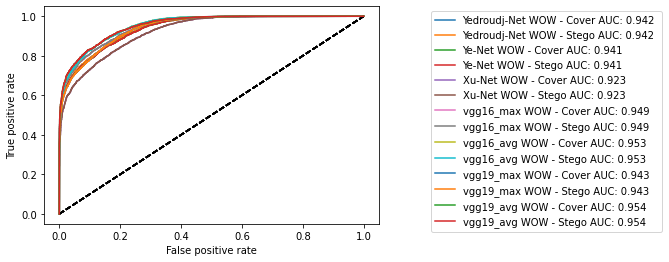

In [ ]:
curves=[curve1,curve2,curve3,curve4,curve5,curve6,curve7]
labels=[labels1,labels2,labels3,labels4,labels5,labels6,labels7]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.pdf', format='pdf')

#### BOSSbase 1.01 + BOWS2

In [ ]:
#Dataset

PATH04_WOW2 = "/WOW_04bpp_BOSS-BOWS2/"

#Train
X_train = np.load(PATH04+PATH04_WOW2+'X_train.npy')
y_train = np.load(PATH04+PATH04_WOW2+'y_train.npy')
#Valid
X_valid = np.load(PATH04+PATH04_WOW2+'X_valid.npy')
y_valid = np.load(PATH04+PATH04_WOW2+'y_valid.npy')
#Test
X_test = np.load(PATH04+PATH04_WOW2+'X_test.npy')
y_test = np.load(PATH04+PATH04_WOW2+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="04WOW2"

### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net WOW - "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net WOW - "
curve2,labels2=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights(" ")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net WOW - "
curve3,labels3=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max WOW - "
curve4,labels4=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg WOW - "
curve5,labels5=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights(")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max WOW - "
curve6,labels6=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg WOW - "
curve7,labels7=get_curve(y_test, predictions, labels,model_name)

## S-UNIWARD

#### BOSSbase 1.01

In [ ]:
#Dataset

PATH04_S_UNIWARD1 = "/SUNIWARD_04bpp_BOSS/"

#Train
X_train = np.load(PATH04+PATH04_S_UNIWARD1+'X_train.npy')
y_train = np.load(PATH04+PATH04_S_UNIWARD1+'y_train.npy')
#Valid
X_valid = np.load(PATH04+PATH04_S_UNIWARD1+'X_valid.npy')
y_valid = np.load(PATH04+PATH04_S_UNIWARD1+'y_valid.npy')
#Test
X_test = np.load(PATH04+PATH04_S_UNIWARD1+'X_test.npy')
y_test = np.load(PATH04+PATH04_S_UNIWARD1+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="04SUNIWARD1"

(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net SUNI - "
curve1_1,labels1_1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net SUNI - "
curve2_1,labels2_1=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net SUNI - "
curve3_1,labels3_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max SUNI - "
curve4_1,labels4_1=get_curve(y_test, predictions, labels,model_name)

VGG16 Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg SUNI - "
curve5_1,labels5_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max SUNI - "
curve6_1,labels6_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg SUNI - "
curve7_1,labels7_1=get_curve(y_test, predictions, labels,model_name)

In [ ]:
curves=[curve1_1,curve2_1,curve3_1,curve4_1,curve5_1,curve6_1,curve7_1]
labels=[labels1_1,labels2_1,labels3_1,labels4_1,labels5_1,labels6_1,labels7_1]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"SUNI0.4"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"SUNI0.4"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"SUNI0.4"+'.pdf', format='pdf')

#### BOSSbase 1.01 + BOWS2

In [ ]:
#Dataset

PATH04_S_UNIWARD2 = "/SUNIWARD_04bpp_BOSS-BOWS2/"

#Train
X_train = np.load(PATH04+PATH04_S_UNIWARD2+'X_train.npy')
y_train = np.load(PATH04+PATH04_S_UNIWARD2+'y_train.npy')
#Valid
X_valid = np.load(PATH04+PATH04_S_UNIWARD2+'X_valid.npy')
y_valid = np.load(PATH04+PATH04_S_UNIWARD2+'y_valid.npy')
#Test
X_test = np.load(PATH04+PATH04_S_UNIWARD2+'X_test.npy')
y_test = np.load(PATH04+PATH04_S_UNIWARD2+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="04SUNIWARD2"

### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net SUNI - "
curve1_1,labels1_1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net SUNI - "
curve2_1,labels2_1=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net SUNI - "
curve3_1,labels3_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max SUNI - "
curve4_1,labels4_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg SUNI - "
curve5_1,labels5_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max SUNI - "
curve6_1,labels6_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg SUNI - "
curve7_1,labels7_1=get_curve(y_test, predictions, labels,model_name)

In [ ]:
curves=[curve1_1,curve2_1,curve3_1,curve4_1,curve5_1,curve6_1,curve7_1]
labels=[labels1_1,labels2_1,labels3_1,labels4_1,labels5_1,labels6_1,labels7_1]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"2SUNI0.4"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"2SUNI0.4"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"2SUNI0.4"+'.pdf', format='pdf')

# PAYLOAD = 0.2bpp

In [ ]:
PATH02 = 'drive/My Drive/Databases/Payload_02bpp'

## WOW

#### BOSSbase 1.01

In [ ]:
#Dataset

PATH02_WOW1 = "/WOW_02bpp_BOSS/"

#Train
X_train = np.load(PATH02+PATH02_WOW1+'X_train.npy')
y_train = np.load(PATH02+PATH02_WOW1+'y_train.npy')
#Valid
X_valid = np.load(PATH02+PATH02_WOW1+'X_valid.npy')
y_valid = np.load(PATH02+PATH02_WOW1+'y_valid.npy')
#Test
X_test = np.load(PATH02+PATH02_WOW1+'X_test.npy')
y_test = np.load(PATH02+PATH02_WOW1+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="02WOW1"

(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net WOW - "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net WOW - "
curve2,labels2=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights(" ")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net WOW - "
curve3,labels3=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max WOW - "
curve4,labels4=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg WOW - "
curve5,labels5=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights(")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max WOW - "
curve6,labels6=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg WOW - "
curve7,labels7=get_curve(y_test, predictions, labels,model_name)

#### ROC CURVES

In [ ]:
curves=[curve1,curve2,curve3,curve4,curve5,curve6,curve7]
labels=[labels1,labels2,labels3,labels4,labels5,labels6,labels7]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"WOW0.4"+'.pdf', format='pdf')

#### BOSSbase 1.01 + BOWS2

In [ ]:
#Dataset

PATH02_WOW2 = "/WOW_02bpp_BOSS-BOWS2/"

#Train
X_train = np.load(PATH02+PATH02_WOW2+'X_train.npy')
y_train = np.load(PATH02+PATH02_WOW2+'y_train.npy')
#Valid
X_valid = np.load(PATH02+PATH02_WOW2+'X_valid.npy')
y_valid = np.load(PATH02+PATH02_WOW2+'y_valid.npy')
#Test
X_test = np.load(PATH02+PATH02_WOW2+'X_test.npy')
y_test = np.load(PATH02+PATH02_WOW2+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="02WOW2"

### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj()  
model.load_weights("") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net WOW - "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("")#best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net WOW - "
curve2,labels2=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights(" ")#best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net WOW - "
curve3,labels3=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max WOW - "
curve4,labels4=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("")#best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg WOW - "
curve5,labels5=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights("")#best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max WOW - "
curve6,labels6=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=100, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg WOW - "
curve7,labels7=get_curve(y_test, predictions, labels,model_name)

## S-UNIWARD

#### BOSSbase 1.01

In [ ]:
#Dataset

PATH02_S_UNIWARD1 = "/SUNIWARD_02bpp_BOSS/"

#Train
X_train = np.load(PATH02+PATH02_S_UNIWARD1+'X_train.npy')
y_train = np.load(PATH02+PATH02_S_UNIWARD1+'y_train.npy')
#Valid
X_valid = np.load(PATH02+PATH02_S_UNIWARD1+'X_valid.npy')
y_valid = np.load(PATH02+PATH02_S_UNIWARD1+'y_valid.npy')
#Test
X_test = np.load(PATH02+PATH02_S_UNIWARD1+'X_test.npy')
y_test = np.load(PATH02+PATH02_S_UNIWARD1+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
base_name="02SUNIWARD1"

(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net SUNI - "
curve1_1,labels1_1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net SUNI - "
curve2_1,labels2_1=get_curve(y_test, predictions, labels,model_name)

##### xu

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net SUNI - "
curve3_1,labels3_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max SUNI - "
curve4_1,labels4_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg SUNI - "
curve5_1,labels5_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max SUNI - "
curve6_1,labels6_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("")#best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg SUNI - "
curve7_1,labels7_1=get_curve(y_test, predictions, labels,model_name)

In [ ]:
curves=[curve1_1,curve2_1,curve3_1,curve4_1,curve5_1,curve6_1,curve7_1]
labels=[labels1_1,labels2_1,labels3_1,labels4_1,labels5_1,labels6_1,labels7_1]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"SUNI0.2"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"SUNI0.2"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"SUNI0.2"+'.pdf', format='pdf')

#### BOSSbase 1.01 + BOWS2

In [ ]:
#Dataset

PATH02_S_UNIWARD2 = "/SUNIWARD_02bpp_BOSS-BOWS2/"

#Train
X_train = np.load(PATH02+PATH02_S_UNIWARD2+'X_train.npy')
y_train = np.load(PATH02+PATH02_S_UNIWARD2+'y_train.npy')
#Valid
X_valid = np.load(PATH02+PATH02_S_UNIWARD2+'X_valid.npy')
y_valid = np.load(PATH02+PATH02_S_UNIWARD2+'y_valid.npy')
#Test
X_test = np.load(PATH02+PATH02_S_UNIWARD2+'X_test.npy')
y_test = np.load(PATH02+PATH02_S_UNIWARD2+'y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

base_name="02SUNIWARD2"

### Redes

Yedroudj-Net

In [ ]:
m_name="Yedroudj_Net"

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_yedroudj() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_yedroudj()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_yedroudj() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Yedroudj-Net SUNI - "
curve1_1,labels1_1=get_curve(y_test, predictions, labels,model_name)

Ye-Net

In [ ]:
m_name="Ye_Net"

In [ ]:
model= get_ye() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_ye() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_ye()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_ye() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Ye-Net SUNI - "
curve2_1,labels2_1=get_curve(y_test, predictions, labels,model_name)

Xu-Net

In [ ]:
m_name="Xu_Net"

In [ ]:
model= get_xu() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

In [ ]:
model= get_xu() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model= get_xu()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_xu() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net SUNI - "
curve3_1,labels3_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Max

In [ ]:
m_name="vgg16_max"

In [ ]:
model=  get_vgg16_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_max() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)

labels = ["Cover","Stego"]
model_name="vgg16_max SUNI - "
curve4_1,labels4_1=get_curve(y_test, predictions, labels,model_name)

VGG16Stego Average

In [ ]:
m_name="vgg16_avg"

In [ ]:
model=  get_vgg16_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg16_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg16_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg16_avg() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg16_avg SUNI - "
curve5_1,labels5_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Max

In [ ]:
m_name="vgg19_max"

In [ ]:
model=  get_vgg19_max()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_max() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_max()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_max() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_max SUNI - "
curve6_1,labels6_1=get_curve(y_test, predictions, labels,model_name)

VGG19Stego Average

In [ ]:
m_name="vgg19_avg"

In [ ]:
model=  get_vgg19_avg()
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=50, model_name=name)

In [ ]:
model=  get_vgg19_avg() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

In [ ]:
model=  get_vgg19_avg()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

In [ ]:
model= get_vgg19_avg() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="vgg19_avg SUNI - "
curve7_1,labels7_1=get_curve(y_test, predictions, labels,model_name)

In [ ]:
curves=[curve1_1,curve2_1,curve3_1,curve4_1,curve5_1,curve6_1,curve7_1]
labels=[labels1_1,labels2_1,labels3_1,labels4_1,labels5_1,labels6_1,labels7_1]

for i in  range(len(curves)):
      plt.title("")
      xlabel = "False positive rate"
      ylabel = "True positive rate"
      curve=curves[i]
      label=labels[i]
      for j in range(2):
        l=label[j]
        a, b = curve
        plt.figure(1, figsize=(180,180))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=l)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1),
                    fancybox=True, ncol=1)
results_dir="/content/drive/My Drive/ROCS/"
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
plt.savefig(results_dir+'ROC_'+"2SUNI0.2"+'.eps', format='eps')
plt.savefig(results_dir+'ROC_'+"2SUNI0.2"+'.svg', format='svg')
plt.savefig(results_dir+'ROC_'+"2SUNI0.2"+'.pdf', format='pdf')